# ABEL scanning example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np
import multiprocessing
num_cores = multiprocessing.cpu_count()
os.environ['NUMEXPR_MAX_THREADS'] = f'{num_cores}'
import time

initializing ocelot...


### Define the linac and beams

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 10000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 10e-15 # [m]

# define stage
stage = StageQuasistatic2dRadiationReaction()
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 11 # [m]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_rr = True

# define first stage (half length)
first_stage = StageQuasistatic2dRadiationReaction()
first_stage.driver_source = stage.driver_source
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_rr = stage.enable_rr

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
source.rel_energy_spread = 0.01
source.bunch_length = 28e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 10000
source.jitter.t = driver.jitter.t

# define interstage
interstage = InterstageBasic()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1 # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 16

### Run simulation scan

In [3]:
# scan the driver timing jitter
start = time.process_time()
linac.scan(f'scan_example_RR_{stage.enable_rr}_160_updated_params_no_jitter', 
           lambda obj, val: setattr(obj.source, 'emit_nx', val) or obj, 
           1e-6*np.array([10, 20, 40, 80, 160]),
           label='Initial normalized emittance in x (mm mrad)',
           scale=1e-6,
           num_shots_per_step=1, 
           parallel=False,
           overwrite=False);  
print((time.process_time() - start)/60)

>> SHOT 1/5
Tracking element 1 (s = 0.0 m, -1.60 nC, 5.0 GeV, SourceBasic, stage 0)


/home/daniel/.local/lib/python3.8/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))


Tracking element 2 (s = 5.5 m, -1.60 nC, 21.9 GeV, StageQuasistatic2dRadiationReaction, stage 1)
Tracking element 3 (s = 12.4 m, -1.60 nC, 21.9 GeV, InterstageBasic, stage 1)
Tracking element 4 (s = 23.4 m, -1.60 nC, 53.5 GeV, StageQuasistatic2dRadiationReaction, stage 2)
Tracking element 5 (s = 34.4 m, -1.60 nC, 53.5 GeV, InterstageBasic, stage 2)
Tracking element 6 (s = 45.4 m, -1.60 nC, 86.2 GeV, StageQuasistatic2dRadiationReaction, stage 3)
Tracking element 7 (s = 59.4 m, -1.60 nC, 86.2 GeV, InterstageBasic, stage 3)
Tracking element 8 (s = 70.4 m, -1.60 nC, 117.2 GeV, StageQuasistatic2dRadiationReaction, stage 4)
Tracking element 9 (s = 86.7 m, -1.60 nC, 117.2 GeV, InterstageBasic, stage 4)
Tracking element 10 (s = 97.7 m, -1.60 nC, 148.7 GeV, StageQuasistatic2dRadiationReaction, stage 5)
Tracking element 11 (s = 116.2 m, -1.60 nC, 148.7 GeV, InterstageBasic, stage 5)
Tracking element 12 (s = 127.2 m, -1.60 nC, 180.2 GeV, StageQuasistatic2dRadiationReaction, stage 6)
Tracking elem

### Plot wakefield

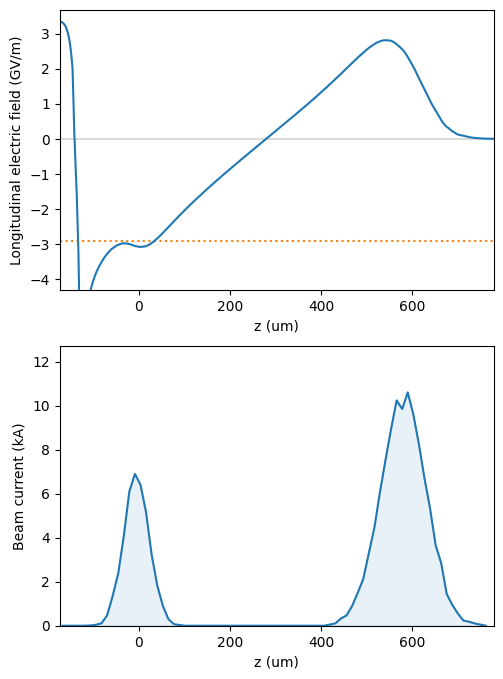

In [4]:
linac.stages[0].plot_wakefield()

### Plot scan

"\nx = np.linspace(0,160,2)\nax4.plot(x,x, label = 'Final = initial')\nax4.legend()\n\nemittance_y_RR = np.zeros(5)\nE_spread_RR = np.zeros(5)\nfor i in range(5):\n    E_spread_RR[i] = linac[i].get_beam(-1).rel_energy_spread()*1e2\n    "

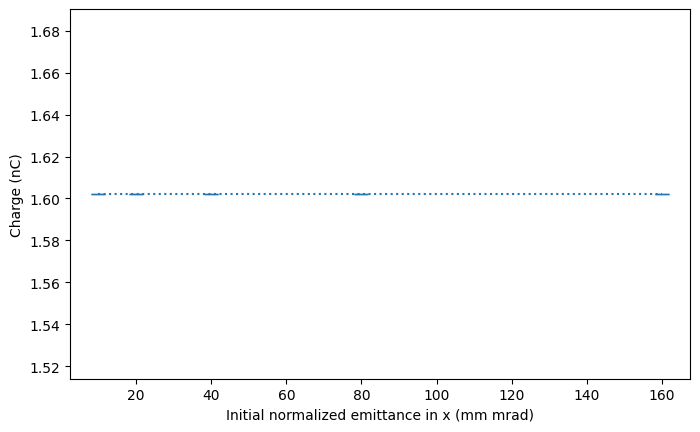

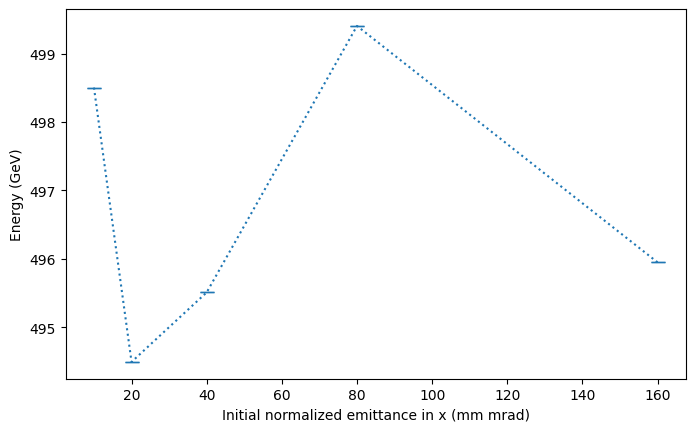

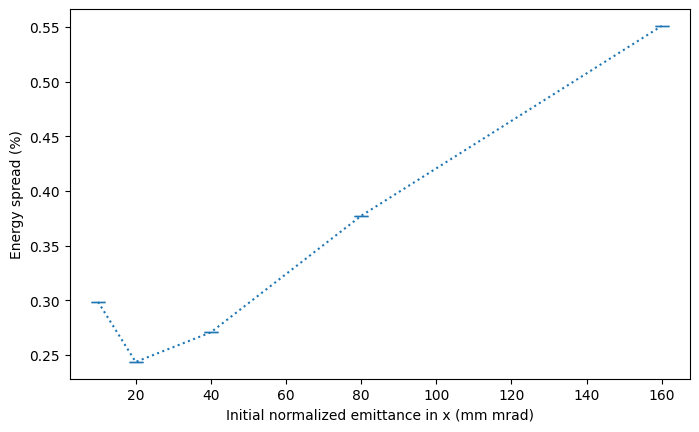

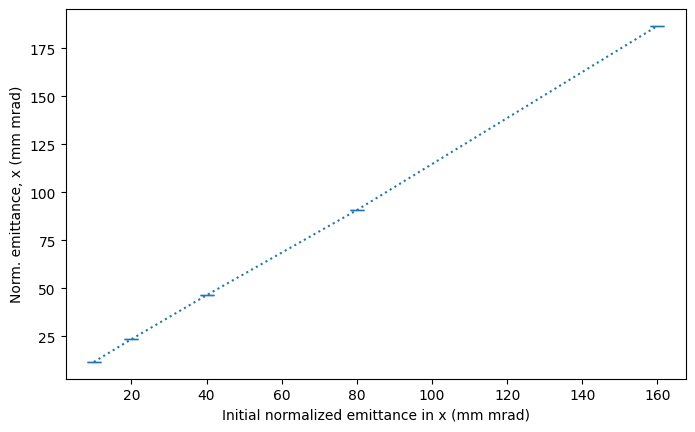

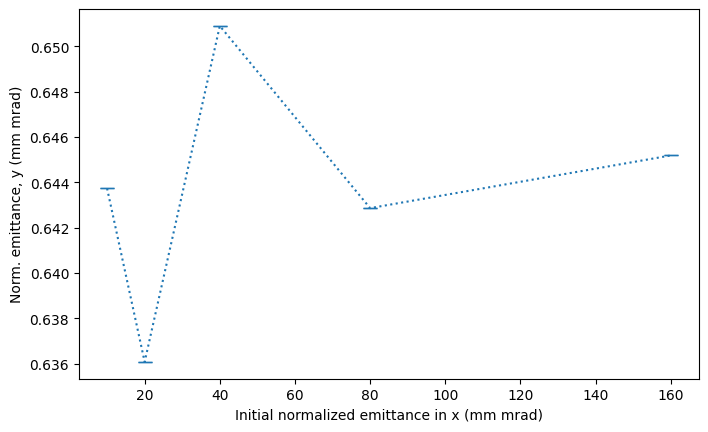

In [5]:
# plot energy spread vs bunch length
fig_1, ax1 = linac.plot_beam_function(Beam.charge, label='Charge (nC)', scale=-1e-9, xscale='linear', yscale='linear')
fig_2, ax2 = linac.plot_beam_function(Beam.energy, label='Energy (GeV)', scale=1e9, xscale='linear', yscale='linear')
fig_3, ax3 = linac.plot_beam_function(Beam.rel_energy_spread, label='Energy spread (%)', scale=1e-2, xscale='linear')
fig_4, ax4 = linac.plot_beam_function(Beam.norm_emittance_x, label='Norm. emittance, x (mm mrad)', scale=1e-6, xscale='linear')
fig_5, ax5 = linac.plot_beam_function(Beam.norm_emittance_y, label='Norm. emittance, y (mm mrad)', scale=1e-6, xscale='linear')
"""
x = np.linspace(0,160,2)
ax4.plot(x,x, label = 'Final = initial')
ax4.legend()

emittance_y_RR = np.zeros(5)
E_spread_RR = np.zeros(5)
for i in range(5):
    E_spread_RR[i] = linac[i].get_beam(-1).rel_energy_spread()*1e2
    """

In [6]:
"""
plots = np.array(['charge', 'energy', 'energy_spread', \
                       'emittance_x', 'emittance_y'])
figs = [fig_1, fig_2, fig_3, fig_4, fig_5]
for pl, f in zip(plots,figs):
    f.savefig(fname = f'Linac_emittance_scan_{pl}_RR_{stage.enable_rr}_160_1T_updated_params.png')
"""

"\nplots = np.array(['charge', 'energy', 'energy_spread',                        'emittance_x', 'emittance_y'])\nfigs = [fig_1, fig_2, fig_3, fig_4, fig_5]\nfor pl, f in zip(plots,figs):\n    f.savefig(fname = f'Linac_emittance_scan_{pl}_RR_{stage.enable_rr}_160_1T_updated_params.png')\n"

In [7]:
#linac[4].animate_lps(file_name=f'emittance_{10*2**4}_RR_false')